In [1]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# model, tokenizer

In [3]:
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

bert = AutoModel.from_pretrained('bert-base-cased')

# model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=25, problem_type = "multi_label_classification")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [71]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [4]:
import torch.nn as nn
from transformers.modeling_outputs import SequenceClassifierOutput

class MultiLabelClassifier(nn.Module):
    def __init__(self, base_model, num_labels):
        super(MultiLabelClassifier, self).__init__()
        self.bert = base_model
        self.num_labels = num_labels
        self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)
        self.dropout = nn.Dropout(base_model.config.hidden_dropout_prob)
        self.config = base_model.config

    def forward(self, input_ids, 
                attention_mask=None, 
                token_type_ids=None,
                labels=None,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=None,):
        

        outputs = self.bert(input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,)
        
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(logits.view(-1, self.num_labels),
                        labels.float().view(-1, self.num_labels))
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

model = MultiLabelClassifier(bert, num_labels=25)

In [4]:
# save the tokenizer

tokenizer.save_pretrained('nyt/BERT_RC/tokenizer')

('nyt/BERT_RC/tokenizer/tokenizer_config.json',
 'nyt/BERT_RC/tokenizer/special_tokens_map.json',
 'nyt/BERT_RC/tokenizer/vocab.txt',
 'nyt/BERT_RC/tokenizer/added_tokens.json')

# data

In [178]:
# load the json file from DocRED/data/test.json and DocRED/data/rel_info.json

import json

# with open('nyt/train.json') as f:
#     train_set = json.load(f)

with open('nyt/train.json') as f:
    train_set = json.load(f)


with open('nyt/words2id.json') as f:
    word2id = json.load(f)

id2word = {v: k for k, v in word2id.items()}


with open('nyt/relations2id.json') as f:
    rel2id_original = json.load(f)



In [174]:


id2head_type = {}
id2tail_type = {}
id2rel = {}

for k, v in rel2id_original.items():
    if k == "None":
        id2head_type[v] = "None"
        id2tail_type[v] = "None"
        id2rel[v] = "None"

    else:
        id2head_type[v] = k.split('/')[1]
        id2tail_type[v] = k.split('/')[2]
        id2rel[v] = k.split('/')[3]

rel2id = {v: k for k, v in id2rel.items()}

In [10]:
"""
the structure of train_set is:

[length]
[words]
[head, tail, relation, head, tail, relation]

"""

"\nthe names of vertextSet can be the same, but the pos should be different\nstructure:\n'vertexSet': \n    [\n        {\n            'pos':[start, end],\n            'type': 'NER',\n            'sent_id': 0,\n            'name': 'string',\n        },\n        {}\n    ]\n'labels':\n    [\n        {\n            'r': 'Pxx',\n            'h': 0,\n            't': 1,\n            'evidence': [2, 3, 4],\n        },\n        {}\n    ]\n'title': 'string',\n'sents':\n    [\n        ['word0', 'word1',]\n        ['word0', 'word1',]\n    ]\n"

In [179]:
from tqdm import tqdm

relation_dict = {
    'text':[],
    'entity': [],
    'relation': []
}
id_count = 0

for i in tqdm(range(len(train_set[0]))):
    

    # text
    sent = ""
    for sent_index, word_id in enumerate(train_set[1][i]):
        word = id2word[word_id]
        # flatten the sent list
        sent += word + " "

    # post process the sents for some spaces
    sents = sent.strip()
    sents = sent.replace("  ", " ")

    relation_dict['text'].append(sent)
            
    # del sents


    # entity
    entity = []
    entity_for_order = []

    # relations
    relation_pairs = {rel:[] for rel in rel2id.keys()}

    for j in range(0, len(train_set[2][i]), 3):
        head_index = train_set[2][i][j]
        head = train_set[1][i][head_index]

        tail_index = train_set[2][i][j + 1]
        tail = train_set[1][i][tail_index]

        relation = id2rel[train_set[2][i][j + 2]]

        if (head_index, id2head_type[train_set[2][i][j + 2]]) not in entity_for_order:
            entity_for_order.append((head_index, id2head_type[train_set[2][i][j + 2]]))
        if (tail_index, id2tail_type[train_set[2][i][j + 2]]) not in entity_for_order:
            entity_for_order.append((tail_index, id2tail_type[train_set[2][i][j + 2]]))
        
        relation_pairs[relation].append((id2word[train_set[1][i][head_index]], id2word[train_set[1][i][tail_index]]))

    # reorder the entity_for_order by the first element of the tuple
    entity_for_order.sort(key=lambda x: x[0])
    for tuple_item in entity_for_order:
        entity.append((id2word[train_set[1][i][tuple_item[0]]], tuple_item[1]))
    
    for j in rel2id.keys():
        if relation_pairs[j] == []:
            relation_pairs[j] = None

    # del entity
    # del entity_for_order


    relation_dict['entity'].append(entity)

    relation_dict['relation'].append(relation_pairs)


    
    # break


# save the relation_dict to a json file

# with open('nyt/data/sent-pre-process.json', 'w') as f:
    # json.dump(relation_dict, f)

100%|██████████| 5000/5000 [00:00<00:00, 38176.47it/s]


In [118]:
len(relation_dict['text']) == len(relation_dict['entity']) == len(relation_dict['relation'])

True

In [124]:
import json

ner = 1
from datasets import Dataset

relation_dict = {}
if ner:
    with open('nyt/data/sent-pre-process.json') as f:
        relation_dict = json.load(f)

    dataset = Dataset.from_dict(
        {
            'text': relation_dict['text'],
            'entity': relation_dict['entity'],
            'relation': relation_dict['relation']
        }
    )

else:
    pass

In [125]:
dataset

Dataset({
    features: ['text', 'entity', 'relation'],
    num_rows: 56195
})

In [126]:
dataset[0]

{'text': 'Massachusetts ASTON MAGNA Great Barrington ; also at Bard College , Annandale-on-Hudson , N.Y. , July 1-Aug . ',
 'entity': [['College', 'location'], ['Annandale-on-Hudson', 'location']],
 'relation': {'None': None,
  'administrative_divisions': None,
  'advisors': None,
  'capital': None,
  'children': None,
  'company': None,
  'contains': [['Annandale-on-Hudson', 'College']],
  'country': None,
  'ethnicity': None,
  'founders': None,
  'geographic_distribution': None,
  'industry': None,
  'location': None,
  'major_shareholder_of': None,
  'major_shareholders': None,
  'nationality': None,
  'neighborhood_of': None,
  'people': None,
  'place_founded': None,
  'place_lived': None,
  'place_of_birth': None,
  'place_of_death': None,
  'profession': None,
  'religion': None,
  'teams': None}}

In [28]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [146]:
def pro_processing_ner(example):
    texts = example['text']
    input_texts = []
    labels = []
    for index in range(len(texts)):
        # entity extraction and NER
        text = texts[index].strip()
        text_w_relation = f"[CLS] " + text + " [SEP]"

        label = [ [0] * 25]
        label = label[0]
        
        for relation_type, relation_pair in example['relation'][index].items():
            if relation_pair:
                # relation classification
                label[rel2id[relation_type]] = 1

            else:
                pass
        input_texts.append(text_w_relation)
        labels.append(label)
    return {
        'input_ids': input_texts, 
        'labels': labels
        }

In [147]:
# feed the dataset:dataset to the pro_processing_ner() function with tokenizer, at each time, we feed 30 examples to the function, and then save the output to a json file
# each time the return of the function is a dict, we need to save the dict to a list, and then save the list to a json file

import json
from tqdm import tqdm


output = {"input_texts": []}
labels = {"labels": []}

for i in tqdm(range(0, len(dataset), 30)):
    result = pro_processing_ner(dataset[i:i+30])
    output["input_texts"].extend(result["input_ids"])
    labels["labels"].extend(result["labels"])

100%|██████████| 1874/1874 [00:04<00:00, 409.83it/s]


In [150]:
output["input_texts"][12]

"[CLS] And Abu Izzadeen , who converted to Islam at 17 and heads another successor group to Al Muhajiroun , called Al Ghurabaa , called suicide bombing '' martyrdom operations . '' [SEP]"

In [151]:
len(output['input_texts'])

56195

In [152]:
# make the output["input_texts"] into a dataset
from datasets import Dataset

input_text_dataset = Dataset.from_dict(
    {
        'input_texts': output['input_texts'],
    }
)

labels_dataset = Dataset.from_dict(
    {
        'labels': labels['labels'],
    }
)


In [153]:
tokenized_dataset = input_text_dataset.map(lambda example: tokenizer(example['input_texts'], padding='max_length', add_special_tokens=False, truncation=True, max_length=512, pad_to_max_length=True), batched=True)

Map:   0%|          | 0/56195 [00:00<?, ? examples/s]

In [154]:
import torch

# add a new column to the tokenized_dataset

tokenized_dataset = tokenized_dataset.add_column('labels', labels['labels'])

In [155]:
# remove the column of input_texts in the tokenized_dataset
tokenized_dataset.remove_columns('input_texts')

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 56195
})

In [156]:
# save the tokenized_dataset

tokenized_dataset.save_to_disk('nyt/BERT_RC/train_data_RC')
# with open('DocRED/data/train_ner_short_relation.json', 'w') as f:
#     json.dump(tokenized_dataset, f)

Saving the dataset (0/1 shards):   0%|          | 0/56195 [00:00<?, ? examples/s]

In [5]:
from datasets import Dataset

tokenized_dataset = Dataset.load_from_disk('nyt/BERT_RC/train_data_RC')
tokenized_dataset = tokenized_dataset.remove_columns('input_texts')

In [6]:
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [7]:
tokenized_dataset.__getitems__([1,4])

[{'input_ids': tensor([  101,  1456,  2938, 23616,  9272,  9637,  2249,   150, 13329,  9741,
            143,  9919, 21669, 12152,  2162, 22412, 10090,   117,  1340,  1512,
            118,  1351,  1476,   119,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,    

In [8]:
import torch

model.eval()

with torch.no_grad():
    outputs = model(input_ids=tokenized_dataset['input_ids'][0:2], attention_mask=tokenized_dataset['attention_mask'][0:2], labels=tokenized_dataset['labels'][0:2])

# Evaluation

In [1]:
import evaluate

import numpy as np

# load the json file from DocRED/data/test.json and DocRED/data/rel_info.json

import json

# with open('nyt/train.json') as f:
#     train_set = json.load(f)

with open('nyt/train.json') as f:
    train_set = json.load(f)


with open('nyt/words2id.json') as f:
    word2id = json.load(f)

id2word = {v: k for k, v in word2id.items()}


with open('nyt/relations2id.json') as f:
    rel2id_original = json.load(f)



id2head_type = {}
id2tail_type = {}
id2rel = {}

for k, v in rel2id_original.items():
    if k == "None":
        id2head_type[v] = "None"
        id2tail_type[v] = "None"
        id2rel[v] = "None"

    else:
        id2head_type[v] = k.split('/')[1]
        id2tail_type[v] = k.split('/')[2]
        id2rel[v] = k.split('/')[3]

rel2id = {v: k for k, v in id2rel.items()}


def compute_metrics(eval_preds):
    logits, labels = eval_preds

    # for the -1 dim of the logits, if the value is larger than 0, then the prediction is 1, else 0
    predictions = np.where(logits > 0, 1, 0)

    # if label is tensor, set the label to numpy
    if isinstance(labels, torch.Tensor):
        labels = labels.numpy()

    # Total accuracy
    total_accuracy = np.mean(predictions == labels)

    # Accuracy for -1
    accuracy_0 = np.mean(predictions[labels == 0] == 0)

    
    # Accuracy for 1
    accuracy_1 = np.mean(predictions[labels == 1] == 1)

    # accuracy for each class
    accuracy_0 = np.mean(predictions[:, 0] == labels[:, 0])
    accuracy_1 = np.mean(predictions[:, 1] == labels[:, 1])
    accuracy_2 = np.mean(predictions[:, 2] == labels[:, 2])
    accuracy_3 = np.mean(predictions[:, 3] == labels[:, 3])
    accuracy_4 = np.mean(predictions[:, 4] == labels[:, 4])
    accuracy_5 = np.mean(predictions[:, 5] == labels[:, 5])
    accuracy_6 = np.mean(predictions[:, 6] == labels[:, 6])
    accuracy_7 = np.mean(predictions[:, 7] == labels[:, 7])
    accuracy_8 = np.mean(predictions[:, 8] == labels[:, 8])
    accuracy_9 = np.mean(predictions[:, 9] == labels[:, 9])
    accuracy_10 = np.mean(predictions[:, 10] == labels[:, 10])
    accuracy_11 = np.mean(predictions[:, 11] == labels[:, 11])
    accuracy_12 = np.mean(predictions[:, 12] == labels[:, 12])
    accuracy_13 = np.mean(predictions[:, 13] == labels[:, 13])
    accuracy_14 = np.mean(predictions[:, 14] == labels[:, 14])
    accuracy_15 = np.mean(predictions[:, 15] == labels[:, 15])
    accuracy_16 = np.mean(predictions[:, 16] == labels[:, 16])
    accuracy_17 = np.mean(predictions[:, 17] == labels[:, 17])
    accuracy_18 = np.mean(predictions[:, 18] == labels[:, 18])
    accuracy_19 = np.mean(predictions[:, 19] == labels[:, 19])
    accuracy_20 = np.mean(predictions[:, 20] == labels[:, 20])
    accuracy_21 = np.mean(predictions[:, 21] == labels[:, 21])
    accuracy_22 = np.mean(predictions[:, 22] == labels[:, 22])
    accuracy_23 = np.mean(predictions[:, 23] == labels[:, 23])
    accuracy_24 = np.mean(predictions[:, 24] == labels[:, 24])

    return {
        "precision_for_1": accuracy_1,
        "precision_for_0": accuracy_0,
        "precision_for_all": total_accuracy,
        f"precision_for_{id2rel[0]}": accuracy_0,
        f"precision_for_{id2rel[1]}": accuracy_1,
        f"precision_for_{id2rel[2]}": accuracy_2,
        f"precision_for_{id2rel[3]}": accuracy_3,
        f"precision_for_{id2rel[4]}": accuracy_4,
        f"precision_for_{id2rel[5]}": accuracy_5,
        f"precision_for_{id2rel[6]}": accuracy_6,
        f"precision_for_{id2rel[7]}": accuracy_7,
        f"precision_for_{id2rel[8]}": accuracy_8,
        f"precision_for_{id2rel[9]}": accuracy_9,
        f"precision_for_{id2rel[10]}": accuracy_10,
        f"precision_for_{id2rel[11]}": accuracy_11,
        f"precision_for_{id2rel[12]}": accuracy_12,
        f"precision_for_{id2rel[13]}": accuracy_13,
        f"precision_for_{id2rel[14]}": accuracy_14,
        f"precision_for_{id2rel[15]}": accuracy_15,
        f"precision_for_{id2rel[16]}": accuracy_16,
        f"precision_for_{id2rel[17]}": accuracy_17,
        f"precision_for_{id2rel[18]}": accuracy_18,
        f"precision_for_{id2rel[19]}": accuracy_19,
        f"precision_for_{id2rel[20]}": accuracy_20,
        f"precision_for_{id2rel[21]}": accuracy_21,
        f"precision_for_{id2rel[22]}": accuracy_22,
        f"precision_for_{id2rel[23]}": accuracy_23,
        f"precision_for_{id2rel[24]}": accuracy_24,
    }

In [10]:
compute_metrics((outputs[1], tokenized_dataset['labels'][0:2]))

{'precision_for_1': 0.0,
 'precision_for_0': 0.5,
 'precision_for_all': 0.4,
 'precision_for_None': 0.5,
 'precision_for_founders': 0.0,
 'precision_for_place_of_birth': 1.0,
 'precision_for_place_of_death': 1.0,
 'precision_for_major_shareholder_of': 0.0,
 'precision_for_people': 0.0,
 'precision_for_neighborhood_of': 0.0,
 'precision_for_location': 1.0,
 'precision_for_company': 0.0,
 'precision_for_industry': 0.0,
 'precision_for_place_founded': 1.0,
 'precision_for_country': 0.0,
 'precision_for_teams': 0.0,
 'precision_for_nationality': 0.0,
 'precision_for_religion': 1.0,
 'precision_for_advisors': 1.0,
 'precision_for_ethnicity': 0.0,
 'precision_for_geographic_distribution': 0.0,
 'precision_for_place_lived': 0.0,
 'precision_for_major_shareholders': 1.0,
 'precision_for_profession': 0.5,
 'precision_for_capital': 1.0,
 'precision_for_contains': 1.0,
 'precision_for_administrative_divisions': 0.0,
 'precision_for_children': 0.0}

In [11]:
# valid_dataset

from datasets import Dataset

valid_dataset = Dataset.load_from_disk('nyt/BERT_RC/test_data_RC')
valid_dataset = valid_dataset.remove_columns('input_texts')


# random sample 1 example from the test_dataset
import random
# have a random seed
random.seed(65)


random_test_index = random.randint(0, len(valid_dataset))


# print(tokenizer.decode(tokenized_test_dataset[random_test_index * 96]['input_ids']))

# output the length of tokenized_test_dataset[index]['input_ids'] except the padding tokens. the tokenized_test_dataset[index]['input_ids'] is tensor

valid_dataset = valid_dataset[random_test_index : random_test_index + 10]

valid_dataset = Dataset.from_dict(
    {
        'input_ids': valid_dataset['input_ids'],
        'attention_mask': valid_dataset['attention_mask'],
        'labels': valid_dataset['labels']
    }
)


valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# trainer

In [19]:
import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="BERT-intermediate",
    # notes="PubmedBERT-FT-NER_w_NERin_10epochs",
    name="onlyRC_nyt-25output_5epochs"
)

eval/loss,▁
eval/precision_for_0,▁
eval/precision_for_1,▁
eval/precision_for_None,▁
eval/precision_for_administrative_divisions,▁
eval/precision_for_advisors,▁
eval/precision_for_all,▁
eval/precision_for_capital,▁
eval/precision_for_children,▁
eval/precision_for_company,▁
eval/precision_for_contains,▁


In [14]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 56195
})

In [20]:
import transformers
from transformers import TrainingArguments, Trainer
import torch.nn as nn


training_args = TrainingArguments(
    output_dir='nyt/BERT_RC',
    num_train_epochs=5,
    auto_find_batch_size=True,
    load_best_model_at_end=True,
    warmup_steps=1000,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    report_to="wandb",
    save_strategy="epoch",
)


class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs[1]
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, 25),
                        labels.float().view(-1, 25))
        return (loss, outputs) if return_outputs else loss

trainer = MultilabelTrainer(
    model=model, 
    train_dataset=tokenized_dataset,
    eval_dataset=valid_dataset,
    args=training_args,
    compute_metrics=compute_metrics,
    )


In [21]:
trainer.train()

/home/tian/mambaforge/envs/BioRED/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/35125 [00:00<?, ?it/s]

{'loss': 0.0718, 'learning_rate': 2.5e-05, 'epoch': 0.07}
{'loss': 0.0526, 'learning_rate': 5e-05, 'epoch': 0.14}
{'loss': 0.0515, 'learning_rate': 4.9267399267399275e-05, 'epoch': 0.21}
{'loss': 0.0452, 'learning_rate': 4.8534798534798533e-05, 'epoch': 0.28}
{'loss': 0.0411, 'learning_rate': 4.7802197802197806e-05, 'epoch': 0.36}
{'loss': 0.0398, 'learning_rate': 4.706959706959707e-05, 'epoch': 0.43}
{'loss': 0.0356, 'learning_rate': 4.6336996336996343e-05, 'epoch': 0.5}
{'loss': 0.0374, 'learning_rate': 4.56043956043956e-05, 'epoch': 0.57}
{'loss': 0.0339, 'learning_rate': 4.4871794871794874e-05, 'epoch': 0.64}
{'loss': 0.0313, 'learning_rate': 4.413919413919414e-05, 'epoch': 0.71}
{'loss': 0.0328, 'learning_rate': 4.340659340659341e-05, 'epoch': 0.78}
{'loss': 0.0296, 'learning_rate': 4.267399267399267e-05, 'epoch': 0.85}
{'loss': 0.0324, 'learning_rate': 4.194139194139194e-05, 'epoch': 0.93}
{'loss': 0.0282, 'learning_rate': 4.120879120879121e-05, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.02058527246117592, 'eval_precision_for_1': 1.0, 'eval_precision_for_0': 1.0, 'eval_precision_for_all': 0.988, 'eval_precision_for_None': 1.0, 'eval_precision_for_founders': 1.0, 'eval_precision_for_place_of_birth': 0.9, 'eval_precision_for_place_of_death': 0.9, 'eval_precision_for_major_shareholder_of': 1.0, 'eval_precision_for_people': 1.0, 'eval_precision_for_neighborhood_of': 1.0, 'eval_precision_for_location': 1.0, 'eval_precision_for_company': 1.0, 'eval_precision_for_industry': 1.0, 'eval_precision_for_place_founded': 1.0, 'eval_precision_for_country': 1.0, 'eval_precision_for_teams': 1.0, 'eval_precision_for_nationality': 0.9, 'eval_precision_for_religion': 1.0, 'eval_precision_for_advisors': 1.0, 'eval_precision_for_ethnicity': 1.0, 'eval_precision_for_geographic_distribution': 1.0, 'eval_precision_for_place_lived': 1.0, 'eval_precision_for_major_shareholders': 1.0, 'eval_precision_for_profession': 1.0, 'eval_precision_for_capital': 1.0, 'eval_precision_for_cont

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.007323176600039005, 'eval_precision_for_1': 1.0, 'eval_precision_for_0': 1.0, 'eval_precision_for_all': 1.0, 'eval_precision_for_None': 1.0, 'eval_precision_for_founders': 1.0, 'eval_precision_for_place_of_birth': 1.0, 'eval_precision_for_place_of_death': 1.0, 'eval_precision_for_major_shareholder_of': 1.0, 'eval_precision_for_people': 1.0, 'eval_precision_for_neighborhood_of': 1.0, 'eval_precision_for_location': 1.0, 'eval_precision_for_company': 1.0, 'eval_precision_for_industry': 1.0, 'eval_precision_for_place_founded': 1.0, 'eval_precision_for_country': 1.0, 'eval_precision_for_teams': 1.0, 'eval_precision_for_nationality': 1.0, 'eval_precision_for_religion': 1.0, 'eval_precision_for_advisors': 1.0, 'eval_precision_for_ethnicity': 1.0, 'eval_precision_for_geographic_distribution': 1.0, 'eval_precision_for_place_lived': 1.0, 'eval_precision_for_major_shareholders': 1.0, 'eval_precision_for_profession': 1.0, 'eval_precision_for_capital': 1.0, 'eval_precision_for_conta

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.0030725165270268917, 'eval_precision_for_1': 1.0, 'eval_precision_for_0': 1.0, 'eval_precision_for_all': 1.0, 'eval_precision_for_None': 1.0, 'eval_precision_for_founders': 1.0, 'eval_precision_for_place_of_birth': 1.0, 'eval_precision_for_place_of_death': 1.0, 'eval_precision_for_major_shareholder_of': 1.0, 'eval_precision_for_people': 1.0, 'eval_precision_for_neighborhood_of': 1.0, 'eval_precision_for_location': 1.0, 'eval_precision_for_company': 1.0, 'eval_precision_for_industry': 1.0, 'eval_precision_for_place_founded': 1.0, 'eval_precision_for_country': 1.0, 'eval_precision_for_teams': 1.0, 'eval_precision_for_nationality': 1.0, 'eval_precision_for_religion': 1.0, 'eval_precision_for_advisors': 1.0, 'eval_precision_for_ethnicity': 1.0, 'eval_precision_for_geographic_distribution': 1.0, 'eval_precision_for_place_lived': 1.0, 'eval_precision_for_major_shareholders': 1.0, 'eval_precision_for_profession': 1.0, 'eval_precision_for_capital': 1.0, 'eval_precision_for_cont

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.0009672858868725598, 'eval_precision_for_1': 1.0, 'eval_precision_for_0': 1.0, 'eval_precision_for_all': 1.0, 'eval_precision_for_None': 1.0, 'eval_precision_for_founders': 1.0, 'eval_precision_for_place_of_birth': 1.0, 'eval_precision_for_place_of_death': 1.0, 'eval_precision_for_major_shareholder_of': 1.0, 'eval_precision_for_people': 1.0, 'eval_precision_for_neighborhood_of': 1.0, 'eval_precision_for_location': 1.0, 'eval_precision_for_company': 1.0, 'eval_precision_for_industry': 1.0, 'eval_precision_for_place_founded': 1.0, 'eval_precision_for_country': 1.0, 'eval_precision_for_teams': 1.0, 'eval_precision_for_nationality': 1.0, 'eval_precision_for_religion': 1.0, 'eval_precision_for_advisors': 1.0, 'eval_precision_for_ethnicity': 1.0, 'eval_precision_for_geographic_distribution': 1.0, 'eval_precision_for_place_lived': 1.0, 'eval_precision_for_major_shareholders': 1.0, 'eval_precision_for_profession': 1.0, 'eval_precision_for_capital': 1.0, 'eval_precision_for_cont

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.0008542523719370365, 'eval_precision_for_1': 1.0, 'eval_precision_for_0': 1.0, 'eval_precision_for_all': 1.0, 'eval_precision_for_None': 1.0, 'eval_precision_for_founders': 1.0, 'eval_precision_for_place_of_birth': 1.0, 'eval_precision_for_place_of_death': 1.0, 'eval_precision_for_major_shareholder_of': 1.0, 'eval_precision_for_people': 1.0, 'eval_precision_for_neighborhood_of': 1.0, 'eval_precision_for_location': 1.0, 'eval_precision_for_company': 1.0, 'eval_precision_for_industry': 1.0, 'eval_precision_for_place_founded': 1.0, 'eval_precision_for_country': 1.0, 'eval_precision_for_teams': 1.0, 'eval_precision_for_nationality': 1.0, 'eval_precision_for_religion': 1.0, 'eval_precision_for_advisors': 1.0, 'eval_precision_for_ethnicity': 1.0, 'eval_precision_for_geographic_distribution': 1.0, 'eval_precision_for_place_lived': 1.0, 'eval_precision_for_major_shareholders': 1.0, 'eval_precision_for_profession': 1.0, 'eval_precision_for_capital': 1.0, 'eval_precision_for_cont

TrainOutput(global_step=35125, training_loss=0.01721924410511166, metrics={'train_runtime': 16307.8052, 'train_samples_per_second': 17.229, 'train_steps_per_second': 2.154, 'train_loss': 0.01721924410511166, 'epoch': 5.0})

In [11]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 56195
})

In [22]:
wandb.finish()
trainer.save_model("nyt/BERT_RC/model-5epochs")

# save the tokenizer
tokenizer.save_pretrained("nyt/BERT_RC/tokenizer")

eval/loss,█▃▂▁▁
eval/precision_for_0,▁▁▁▁▁
eval/precision_for_1,▁▁▁▁▁
eval/precision_for_None,▁▁▁▁▁
eval/precision_for_administrative_divisions,▁▁▁▁▁
eval/precision_for_advisors,▁▁▁▁▁
eval/precision_for_all,▁████
eval/precision_for_capital,▁▁▁▁▁
eval/precision_for_children,▁▁▁▁▁
eval/precision_for_company,▁▁▁▁▁
eval/precision_for_contains,▁▁▁▁▁


('nyt/BERT_RC/tokenizer/tokenizer_config.json',
 'nyt/BERT_RC/tokenizer/special_tokens_map.json',
 'nyt/BERT_RC/tokenizer/vocab.txt',
 'nyt/BERT_RC/tokenizer/added_tokens.json')

# Inference

In [2]:
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

checkpoint = "nyt/BERT_RC/model-5epochs/pytorch_model.bin"

In [3]:
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


import torch.nn as nn
from transformers.modeling_outputs import SequenceClassifierOutput

class MultiLabelClassifier(nn.Module):
    def __init__(self, num_labels):
        super(MultiLabelClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-cased')
        self.num_labels = num_labels
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.config = self.bert.config

    def forward(self, input_ids, 
                attention_mask=None, 
                token_type_ids=None,
                labels=None,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=None,):
        

        outputs = self.bert(input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,)
        
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(logits.view(-1, self.num_labels),
                        labels.float().view(-1, self.num_labels))
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

model = MultiLabelClassifier(num_labels=25)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# from transformers import GPT2Tokenizer
# tokenizer = GPT2Tokenizer.from_pretrained("nyt/BERT_RC/tokenizer")
# using pytorch to load the parameter in "nyt/BERT_RC/model-5epochs/pytorch_model.bin" to the model
import torch

model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

In [11]:
# output all of the special tokens in the tokenizer
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

test data pre-processing

In [181]:
import json

from datasets import Dataset

ner = 1

test_relation_dict = {}
if ner:
    with open('nyt/data/test-sent-pre-process.json') as f:
        test_relation_dict = json.load(f)

    test_dataset = Dataset.from_dict(
        {
            'text': test_relation_dict['text'],
            'entity': test_relation_dict['entity'],
            'relation': test_relation_dict['relation']
        }
    )

else:
    pass


dataset = test_dataset

In [182]:
def pro_processing_ner(example):
    texts = example['text']
    input_texts = []
    labels = []
    for index in range(len(texts)):
        # entity extraction and NER
        text = texts[index].strip()
        text_w_relation = f"[CLS] " + text + " [SEP]"

        label = [ [0] * 25]
        label = label[0]
        
        for relation_type, relation_pair in example['relation'][index].items():
            if relation_pair:
                # relation classification
                label[rel2id[relation_type]] = 1

            else:
                pass
        input_texts.append(text_w_relation)
        labels.append(label)
    return {
        'input_ids': input_texts, 
        'labels': labels
        }

import json
from tqdm import tqdm


output = {"input_texts": []}
test_labels = []

for i in tqdm(range(0, len(dataset), 30)):
    result = pro_processing_ner(dataset[i:i+30])
    output["input_texts"].extend(result["input_ids"])
    test_labels.extend(result["labels"])


from datasets import Dataset

input_text_dataset = Dataset.from_dict(
    {
        'input_texts': output['input_texts'],
    }
)


100%|██████████| 167/167 [00:00<00:00, 387.29it/s]


In [183]:
tokenized_dataset = input_text_dataset.map(lambda example: tokenizer(example['input_texts'], padding='max_length', truncation=True, max_length=512, add_special_tokens=False, pad_to_max_length=True), batched=True)

tokenized_dataset.remove_columns('input_texts')
tokenized_dataset = tokenized_dataset.add_column('labels', test_labels)

tokenized_dataset.save_to_disk('nyt/BERT_RC/test_data_RC')
# with open('DocRED/data/train_ner_short_relation.json', 'w') as f:
#     json.dump(tokenized_dataset, f)



Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

In [6]:
from datasets import Dataset

test_dataset = Dataset.load_from_disk('nyt/BERT_RC/test_data_RC')
# test_dataset = valid_dataset.remove_columns('input_texts')

test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

whole inference

In [6]:
model.eval()
model.to("cpu")

with torch.no_grad():
    outputs = model(input_ids=test_dataset['input_ids'][0:2], attention_mask=test_dataset['attention_mask'][0:2])

In [7]:
compute_metrics((outputs[0], test_dataset['labels'][0:2]))

{'precision_for_1': 1.0,
 'precision_for_0': 1.0,
 'precision_for_all': 0.96,
 'precision_for_None': 1.0,
 'precision_for_founders': 1.0,
 'precision_for_place_of_birth': 1.0,
 'precision_for_place_of_death': 0.5,
 'precision_for_major_shareholder_of': 1.0,
 'precision_for_people': 1.0,
 'precision_for_neighborhood_of': 1.0,
 'precision_for_location': 1.0,
 'precision_for_company': 1.0,
 'precision_for_industry': 1.0,
 'precision_for_place_founded': 1.0,
 'precision_for_country': 1.0,
 'precision_for_teams': 1.0,
 'precision_for_nationality': 0.5,
 'precision_for_religion': 1.0,
 'precision_for_advisors': 1.0,
 'precision_for_ethnicity': 1.0,
 'precision_for_geographic_distribution': 1.0,
 'precision_for_place_lived': 1.0,
 'precision_for_major_shareholders': 1.0,
 'precision_for_profession': 1.0,
 'precision_for_capital': 1.0,
 'precision_for_contains': 1.0,
 'precision_for_administrative_divisions': 1.0,
 'precision_for_children': 1.0}

In [7]:
from tqdm.notebook import trange, tqdm
import torch
import numpy as np

final_result = {
        "precision_for_1": [],
        "precision_for_0": [],
        "precision_for_all": [],
        f"precision_for_{id2rel[0]}": [],
        f"precision_for_{id2rel[1]}": [],
        f"precision_for_{id2rel[2]}": [],
        f"precision_for_{id2rel[3]}": [],
        f"precision_for_{id2rel[4]}": [],
        f"precision_for_{id2rel[5]}": [],
        f"precision_for_{id2rel[6]}": [],
        f"precision_for_{id2rel[7]}": [],
        f"precision_for_{id2rel[8]}": [],
        f"precision_for_{id2rel[9]}": [],
        f"precision_for_{id2rel[10]}": [],
        f"precision_for_{id2rel[11]}": [],
        f"precision_for_{id2rel[12]}": [],
        f"precision_for_{id2rel[13]}": [],
        f"precision_for_{id2rel[14]}": [],
        f"precision_for_{id2rel[15]}": [],
        f"precision_for_{id2rel[16]}": [],
        f"precision_for_{id2rel[17]}": [],
        f"precision_for_{id2rel[18]}": [],
        f"precision_for_{id2rel[19]}": [],
        f"precision_for_{id2rel[20]}": [],
        f"precision_for_{id2rel[21]}": [],
        f"precision_for_{id2rel[22]}": [],
        f"precision_for_{id2rel[23]}": [],
        f"precision_for_{id2rel[24]}": [],
    }


model.eval()
outputs = []
model.to("cuda")
output_results = []


with torch.no_grad():
    # feed the actually_input to the model by 50 examples each time
    for input_index in tqdm(range(0, len(test_dataset), 50)):
        # print(input_index + 1, " / ", len(tokenized_test_dataset))
        input_ids =test_dataset[input_index : input_index+50]["input_ids"].to("cuda")
        attention_mask = test_dataset[input_index : input_index+50]["attention_mask"].to("cuda")

        output = model(input_ids=input_ids, attention_mask=attention_mask)
        # copy output[0] to cpu
        pred = output[0].clone().cpu()
        result = compute_metrics((pred, test_dataset[input_index : input_index+50]["labels"]))

        for k, v in result.items():
            final_result[k].append(v)


result_sum = {}
for k, v in final_result.items():  
    result_sum[k] = sum(v) / 100

print(result_sum)


  0%|          | 0/100 [00:00<?, ?it/s]

{'precision_for_1': 0.9964000000000003, 'precision_for_0': 1.0, 'precision_for_all': 0.9939520000000001, 'precision_for_None': 1.0, 'precision_for_founders': 0.9964000000000003, 'precision_for_place_of_birth': 0.9730000000000003, 'precision_for_place_of_death': 0.9863999999999998, 'precision_for_major_shareholder_of': 0.9988000000000001, 'precision_for_people': 0.9998, 'precision_for_neighborhood_of': 0.9949999999999999, 'precision_for_location': 0.9992, 'precision_for_company': 0.9922, 'precision_for_industry': 1.0, 'precision_for_place_founded': 0.9974000000000001, 'precision_for_country': 0.9940000000000001, 'precision_for_teams': 0.9990000000000001, 'precision_for_nationality': 0.9858000000000001, 'precision_for_religion': 1.0, 'precision_for_advisors': 0.9997999999999999, 'precision_for_ethnicity': 0.9998, 'precision_for_geographic_distribution': 0.9998, 'precision_for_place_lived': 0.9682000000000001, 'precision_for_major_shareholders': 0.9990000000000001, 'precision_for_professi

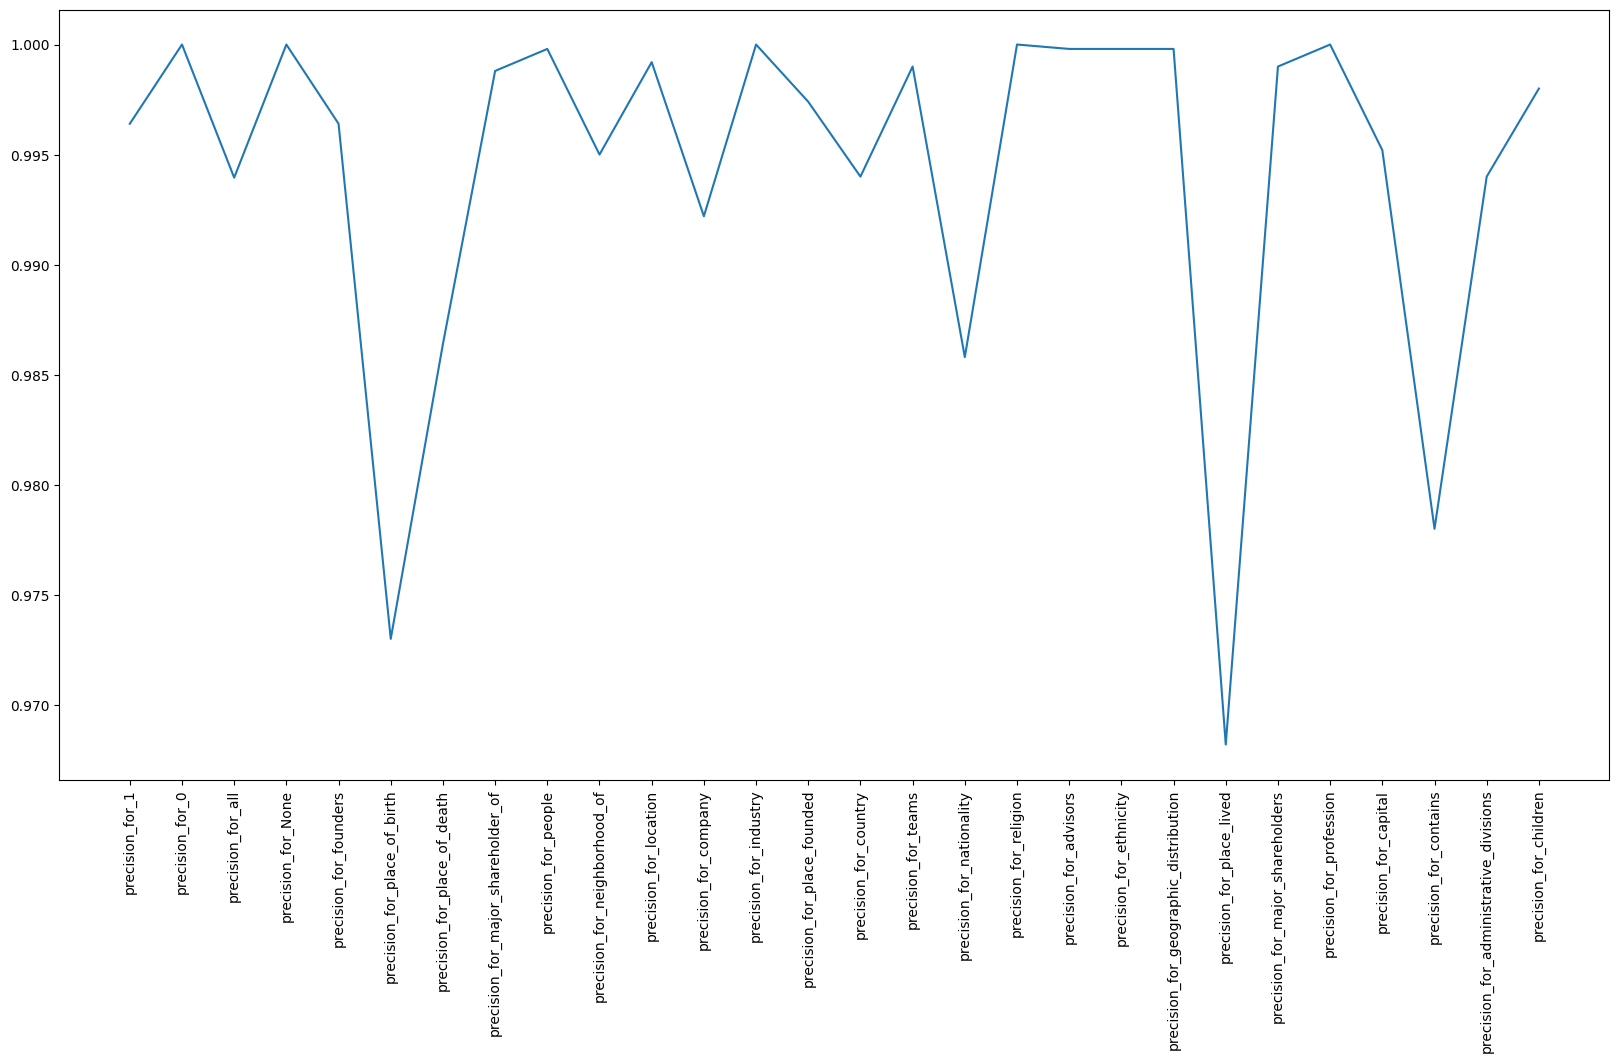

In [8]:
# using matplotlib to plot the final_result

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(result_sum.values())

plt.xticks(range(len(result_sum)), result_sum.keys(), rotation=90)
plt.show()